<a href="https://colab.research.google.com/github/ssoyyoungg/practice/blob/main/CIFAR-10_UPGRADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU 사용

In [22]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


CIFAR-10 데이터 로드

 (데이터 개선하기(정규화 추가))

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

])

transform_train = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


CIFAR용 CNN 모델 정의

In [35]:
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1   = nn.Linear(64*8*8, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CIFAR_CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [36]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [45]:
for epoch in range(1,6):
  train_loss = train_one_epoch(model, train_loader)
  test_acc = evaluate(model, test_loader)
  print(f"Epoch {epoch} | /Train Loss : {train_loss:.4f} | Test Acc : {test_acc*100:.2f}%")

Epoch 1 | /Train Loss : 0.8776 | Test Acc : 74.32%
Epoch 2 | /Train Loss : 0.8606 | Test Acc : 76.00%
Epoch 3 | /Train Loss : 0.8524 | Test Acc : 76.24%
Epoch 4 | /Train Loss : 0.8412 | Test Acc : 76.64%
Epoch 5 | /Train Loss : 0.8280 | Test Acc : 76.54%


데이터 개선 2 : 데이터 증강 (augmentation) 을 사용하여 과적합 완화하기

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,transform=transform_train

)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1   = nn.Linear(64*8*8, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CIFAR_CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [46]:
for epoch in range(1,6):
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch} | /Train Loss : {train_loss:.4f} | Test Acc : {test_acc*100:.2f}%")

Epoch 1 | /Train Loss : 0.8184 | Test Acc : 77.08%
Epoch 2 | /Train Loss : 0.8101 | Test Acc : 77.75%
Epoch 3 | /Train Loss : 0.8044 | Test Acc : 77.97%
Epoch 4 | /Train Loss : 0.7954 | Test Acc : 77.80%
Epoch 5 | /Train Loss : 0.7834 | Test Acc : 78.50%


이전단계보다 Train Loss 감소, Test Acc 증가 하는 걸 확인 가능

모델 업그레이드 3 :

BatchNorm + Dropout

In [47]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

])

transform_train = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transfor_test = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,transform=transform_train

)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1   = nn.Linear(64*8*8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CIFAR_CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


for epoch in range(1,6):
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch} | /Train Loss : {train_loss:.4f} | Test Acc : {test_acc*100:.2f}%")

Epoch 1 | /Train Loss : 1.3084 | Test Acc : 66.86%
Epoch 2 | /Train Loss : 0.9917 | Test Acc : 70.56%
Epoch 3 | /Train Loss : 0.8538 | Test Acc : 72.31%
Epoch 4 | /Train Loss : 0.7573 | Test Acc : 73.20%
Epoch 5 | /Train Loss : 0.6801 | Test Acc : 73.78%


Nomalize + Agumentation + B/N + Dropout

In [48]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,transform=transform_train

)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1   = nn.Linear(64*8*8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CIFAR_CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


for epoch in range(1,6):
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch} | /Train Loss : {train_loss:.4f} | Test Acc : {test_acc*100:.2f}%")

Epoch 1 | /Train Loss : 1.5508 | Test Acc : 57.95%
Epoch 2 | /Train Loss : 1.2634 | Test Acc : 65.96%
Epoch 3 | /Train Loss : 1.1466 | Test Acc : 68.83%
Epoch 4 | /Train Loss : 1.0769 | Test Acc : 68.37%
Epoch 5 | /Train Loss : 1.0249 | Test Acc : 71.25%


오답 TOP 10 & Confusion Matrix

In [49]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Confusion Matrix출력 (CIFAR-10)

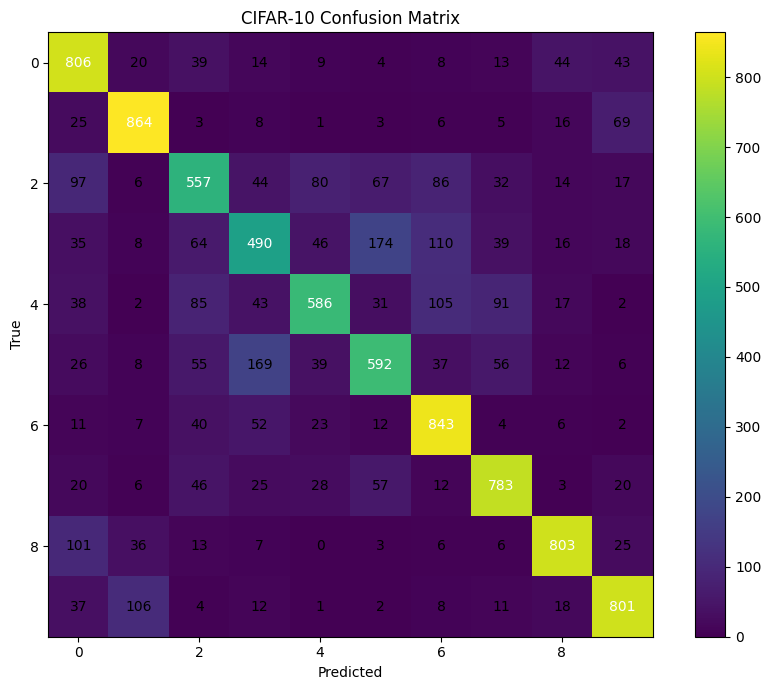

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(9,7))
plt.imshow(cm, interpolation='nearest')
plt.title("CIFAR-10 Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()